# phase1


In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

param/eqn setup

In [68]:
def fhn(t, state, a=0.7, b=0.8, alpha=3, z=-0.5, w=1):
    x, y = state
    dx = alpha*(y + x - (x**3)/3 + z)
    dy = -(1/alpha)*(w**2*x - a + b*y)
    return [dx, dy]

# Time span and initial conditions
t_span = (0, 100)
initial = [0.01, 0.01]

# Time points at which to store the solution
t_eval = np.linspace(t_span[0], t_span[1], 10000)

# Solve the differential equation
solution = solve_ivp(fhn, t_span, initial, t_eval=t_eval)

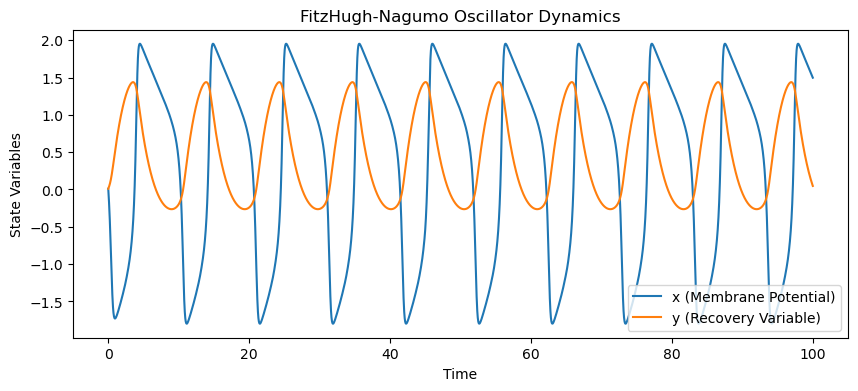

In [69]:
plt.figure(figsize=(10, 4))
plt.plot(solution.t, solution.y[0], label='x (Membrane Potential)')
plt.plot(solution.t, solution.y[1], label='y (Recovery Variable)')
plt.xlabel('Time')
plt.ylabel('State Variables')
plt.legend()
plt.title('FitzHugh-Nagumo Oscillator Dynamics')
plt.show()

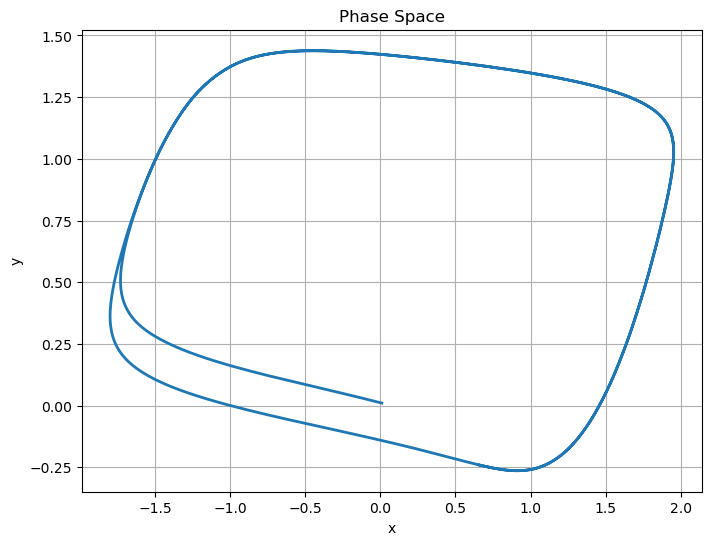

In [249]:
plt.figure(figsize=(8, 6))
plt.plot(solution.y[0], solution.y[1], lw=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Phase Space')
plt.grid(True)
plt.show()

above looks about right

## p1 investigate intrinsic freq

intrinsic frequency as a function of z=const=k for alpha=3


In [76]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks, hilbert
import pywt
from tqdm import tqdm

def fhn(t, state, a=0.7, b=0.8, alpha=3, z=1, w=1):
    x, y = state
    dx = alpha*(y + x - (x**3)/3 + z)
    dy = -(1/alpha)*(w**2*x - a + b*y)
    return [dx, dy]

# init
t_span = (0, 10000)
t_eval = np.linspace(t_span[0], t_span[1], 100000)  
initial_state = [0.00, 0.00]

# z values and logging
z_values = np.linspace(-1.5, -0.2, 500)  
intrinsic_frequencies = []
avg_freqs = []
solutions = []

for z in tqdm(z_values):
    sol = solve_ivp(fhn, t_span, initial_state, t_eval=t_eval, args=(0.7, 0.8, 3, z), method='RK45')
    solutions.append(sol)
    
    transient_mask = sol.t > (t_span[1] / 2)
    t_trans = sol.t[transient_mask]
    x_trans = sol.y[0][transient_mask]

    # # Compute the analytic signal using the Hilbert transform.
    analytic_signal = hilbert(x_trans)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))

    # scale = 1
    # wavelet_name = 'cmor10.0-1.0'

    # coeffs, freqs = pywt.cwt(x_trans, scale, wavelet_name)
    # phase = np.unwrap(np.angle(coeffs[0]))
    # dt = t_trans[1] - t_trans[0]
    # inst_freq = np.diff(phase) / (2 * np.pi * dt)
    # avg_freq = np.mean(inst_freq)
    
    dt = t_trans[1] - t_trans[0]
    # phase to freq
    instantaneous_frequency = np.diff(instantaneous_phase) / (2 * np.pi * dt)
    # Average the instantaneous frequency to obtain the intrinsic frequency.
    avg_frequency = np.mean(instantaneous_frequency)
    avg_freqs.append(avg_frequency)

    intrinsic_frequencies.append(avg_frequency)
    # intrinsic_frequencies.append(avg_freq)

100%|██████████| 500/500 [08:40<00:00,  1.04s/it]


In [74]:
intrinsic_frequencies = np.array(intrinsic_frequencies)

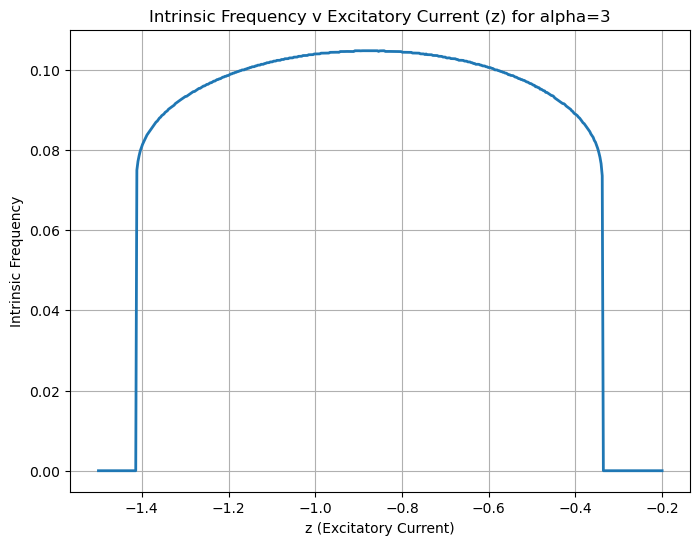

In [77]:
# Plot intrinsic frequency vs. excitatory current (z)
plt.figure(figsize=(8, 6))
plt.plot(z_values, intrinsic_frequencies, lw=2)
plt.xlabel('z (Excitatory Current)')
plt.ylabel('Intrinsic Frequency')
plt.title('Intrinsic Frequency v Excitatory Current (z) for alpha=3')
plt.grid(True)
plt.show()


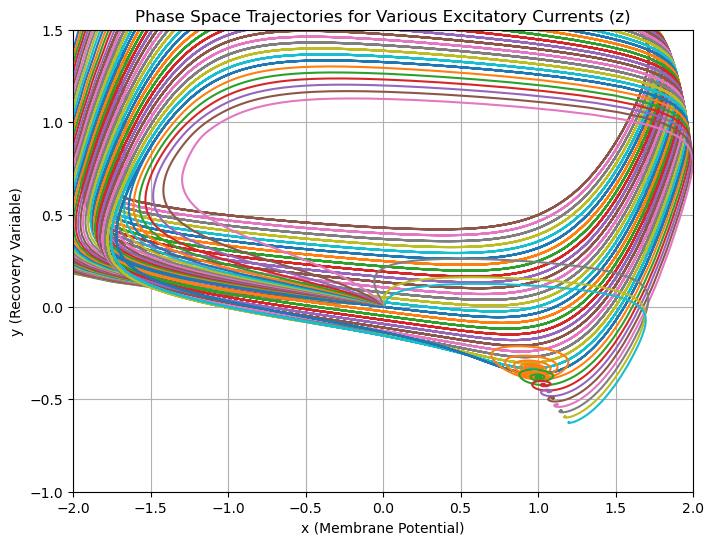

In [257]:
plt.figure(figsize=(8, 6))
for z, sol in zip(z_values, solutions):
    plt.plot(sol.y[0], sol.y[1], 
             )
             #label=f'z = {z:.2f}')

# v      = np.linspace(-2,2,100)
# w_line = -1/0.8 * v + (0.7/3)/(-0.7*1)
# v      = np.linspace(-1.5,1.5,100)
# w_cube = -v + v**3 + 1
# plt.plot(v,w_line, '--')
# plt.plot(v,w_cube,'--')

plt.xlabel('x (Membrane Potential)')
plt.ylabel('y (Recovery Variable)')
plt.title('Phase Space Trajectories for Various Excitatory Currents (z)')
# plt.legend()
plt.axis([-2, 2, -1, 1.5])
plt.grid(True)
plt.show()

## p2 bidirectional coupling

In [14]:
import numba
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import hilbert

# @numba.njit
def coupled_fhn(t, state, k1=1, k2=1, c=1, a=0.7, b=0.8, alpha=3, w=1):
    x1, y1, x2, y2 = state
    dx1 = alpha*(y1 + x1 - (x1**3)/3 + (k1+c*x2))
    dy1 = -(1/alpha)*(w**2*x1 - a + b*y1)
    dx2 = alpha*(y2 + x2 - (x2**3)/3 + (k2+c*x1))
    dy2 = -(1/alpha)*(w**2*x2 - a + b*y2)
    return np.array([dx1, dy1, dx2, dy2])

# init
t_span = (0, 50)
t_eval = np.linspace(t_span[0], t_span[1], 1000)  
initial_state = [0.01, 0.01, 0.01, 0.01]

k1 = -1.0
k2 = -0.2
c  = 0.01
solution = solve_ivp(coupled_fhn, t_span, initial_state, t_eval=t_eval, args=(k1, k2, c), method='Radau')
print(f'{k1/k2}')


5.0


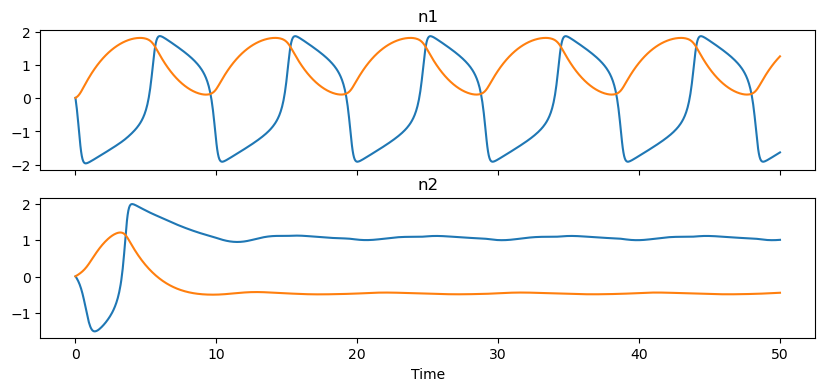

In [86]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 4), sharex=True)

axes[0].plot(solution.t, solution.y[0])
axes[0].plot(solution.t, solution.y[1])
axes[0].set_title(f'n1')

axes[1].plot(solution.t, solution.y[2])
axes[1].plot(solution.t, solution.y[3])
axes[1].set_title(f'n2')

plt.xlabel('Time')
plt.show()



### grid search

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def plot_results(c_values, delta_ratio_values, freq_diff_matrix, R_matrix):
    """
    Plot the results of the grid search experiment.
    
    Parameters:
        c_values (np.ndarray): Array of coupling factors.
        delta_ratio_values (np.ndarray): Array of dk/k₁ values.
        freq_diff_matrix (np.ndarray): Matrix of absolute frequency differences.
        R_matrix (np.ndarray): Matrix of the synchronicity index R.
    """
    yaxis = (delta_ratio_values)/(1.4)
    X, Y = np.meshgrid(c_values, yaxis)
    
    plt.figure(figsize=(24, 10))
    
    # Plot the synchronicity index R.
    plt.subplot(1, 2, 1)
    contour1 = plt.contourf(X, Y, R_matrix, levels=40, cmap='plasma')
    plt.colorbar(contour1, label='R')
    plt.xlabel('Coupling Factor (c)')
    plt.ylabel(r'$\Delta k/k_1$')
    plt.title('Phase Coherence Index')
    
    # Plot the frequency difference.
    plt.subplot(1, 2, 2)
    contour2 = plt.contourf(X, Y, freq_diff_matrix, levels=40, cmap='viridis')
    plt.colorbar(contour2, label='|Frequency Difference| (Hz)')
    plt.xlabel('Coupling Factor (c)')
    plt.ylabel(r'$\Delta k/k_1$')
    plt.title('Frequency Difference')
    
    plt.tight_layout()
    plt.show()

In [4]:
from utils import run_experiment_floop, run_experiment_parallel
transform_method = 'hilbert'  # or 'wavelet'

c_vals, delta_ratios, freq_diff, R_mat = run_experiment_parallel(resolution=500,
                                                                 n_jobs=14)

500it [25:05,  3.01s/it]


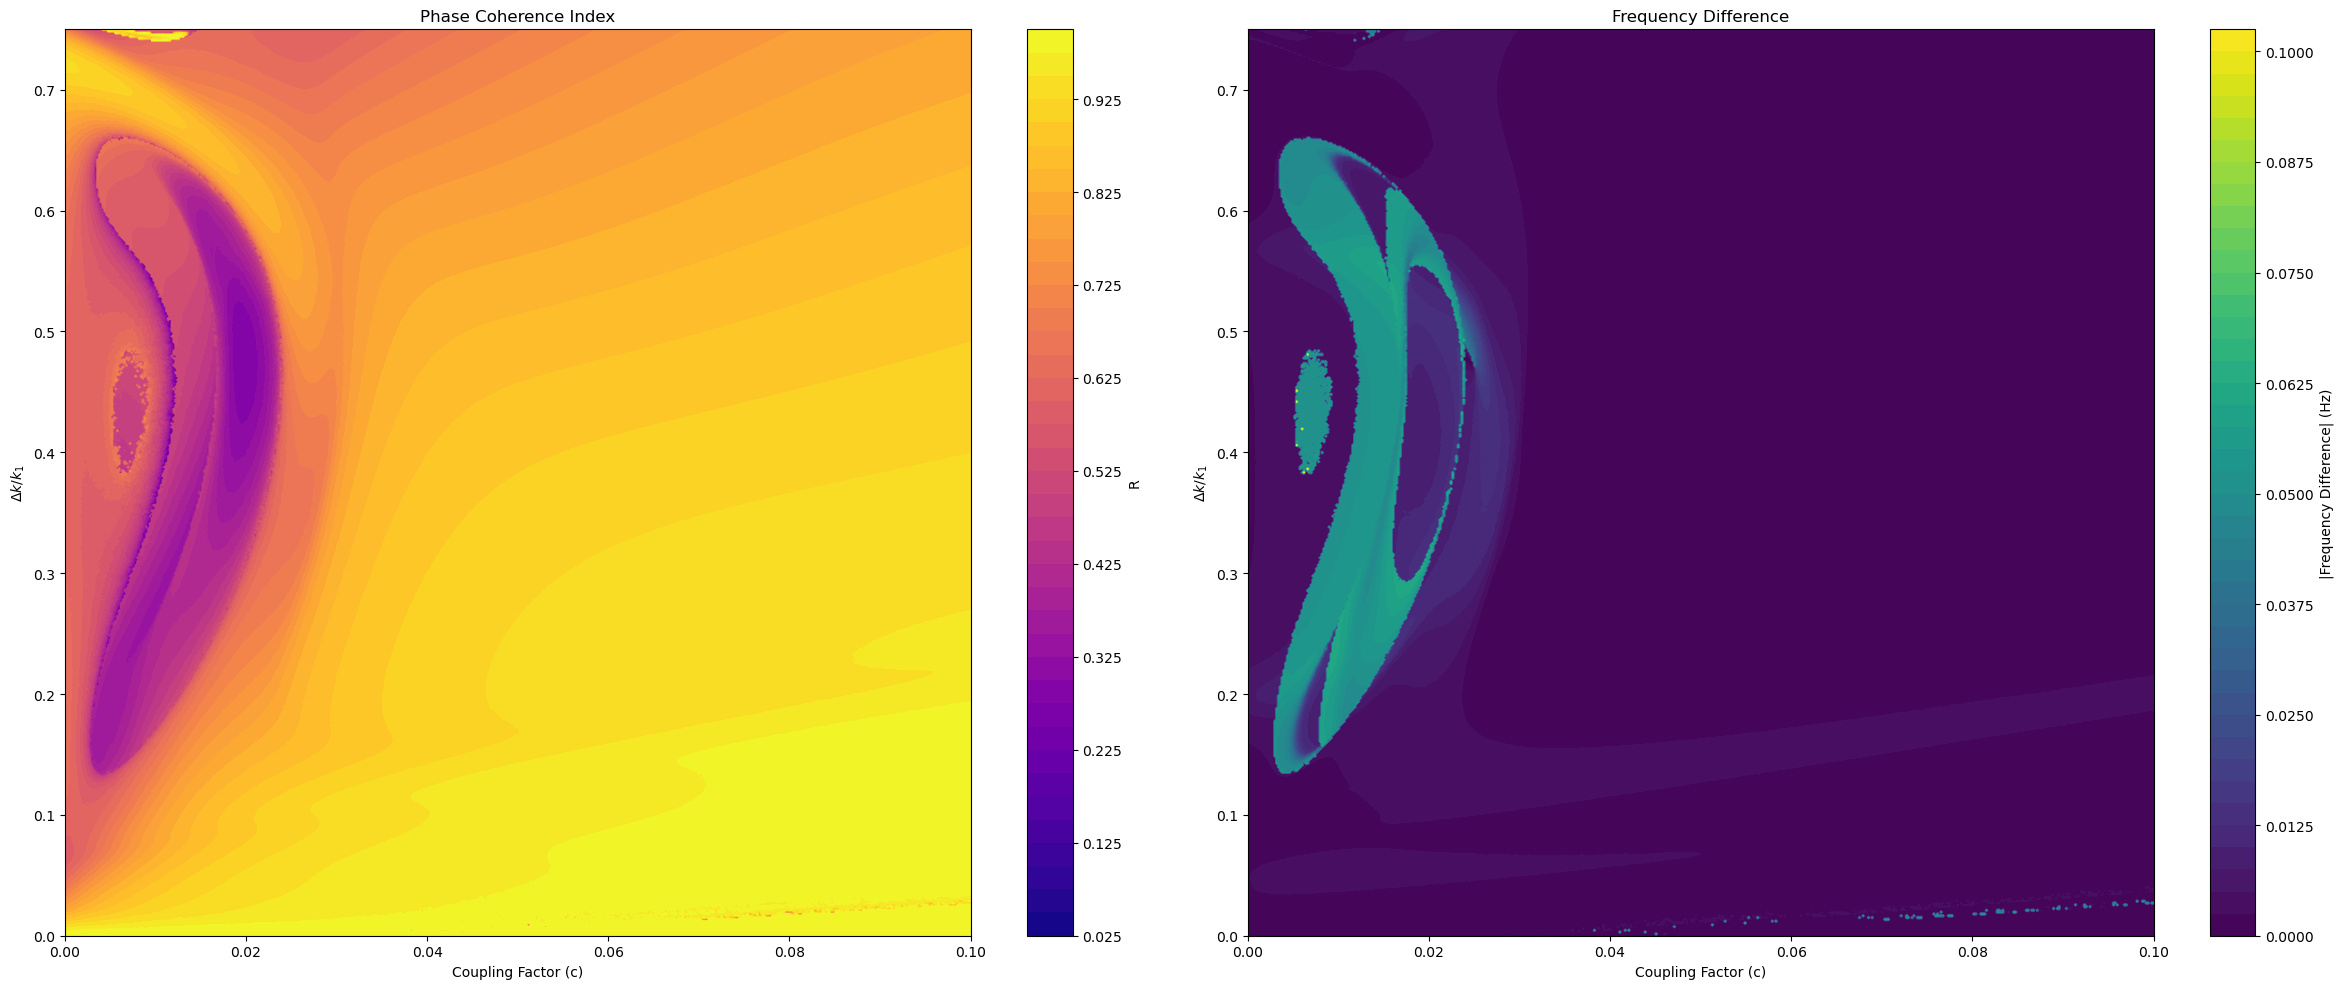

In [5]:
# print(coupled_fhn.inspect_types())
plot_results(c_vals, delta_ratios, freq_diff, R_mat)

In [5]:
from utils import run_experiment_parallel

c_vals, delta_ratios, freq_diff, R_mat = run_experiment_parallel(resolution=500,
                                                                 transformation='wavelet',
                                                                 n_jobs=14,
                                                                 wavelet="cmor0.1-0.1")

0it [00:00, ?it/s]

500it [21:24,  2.57s/it]


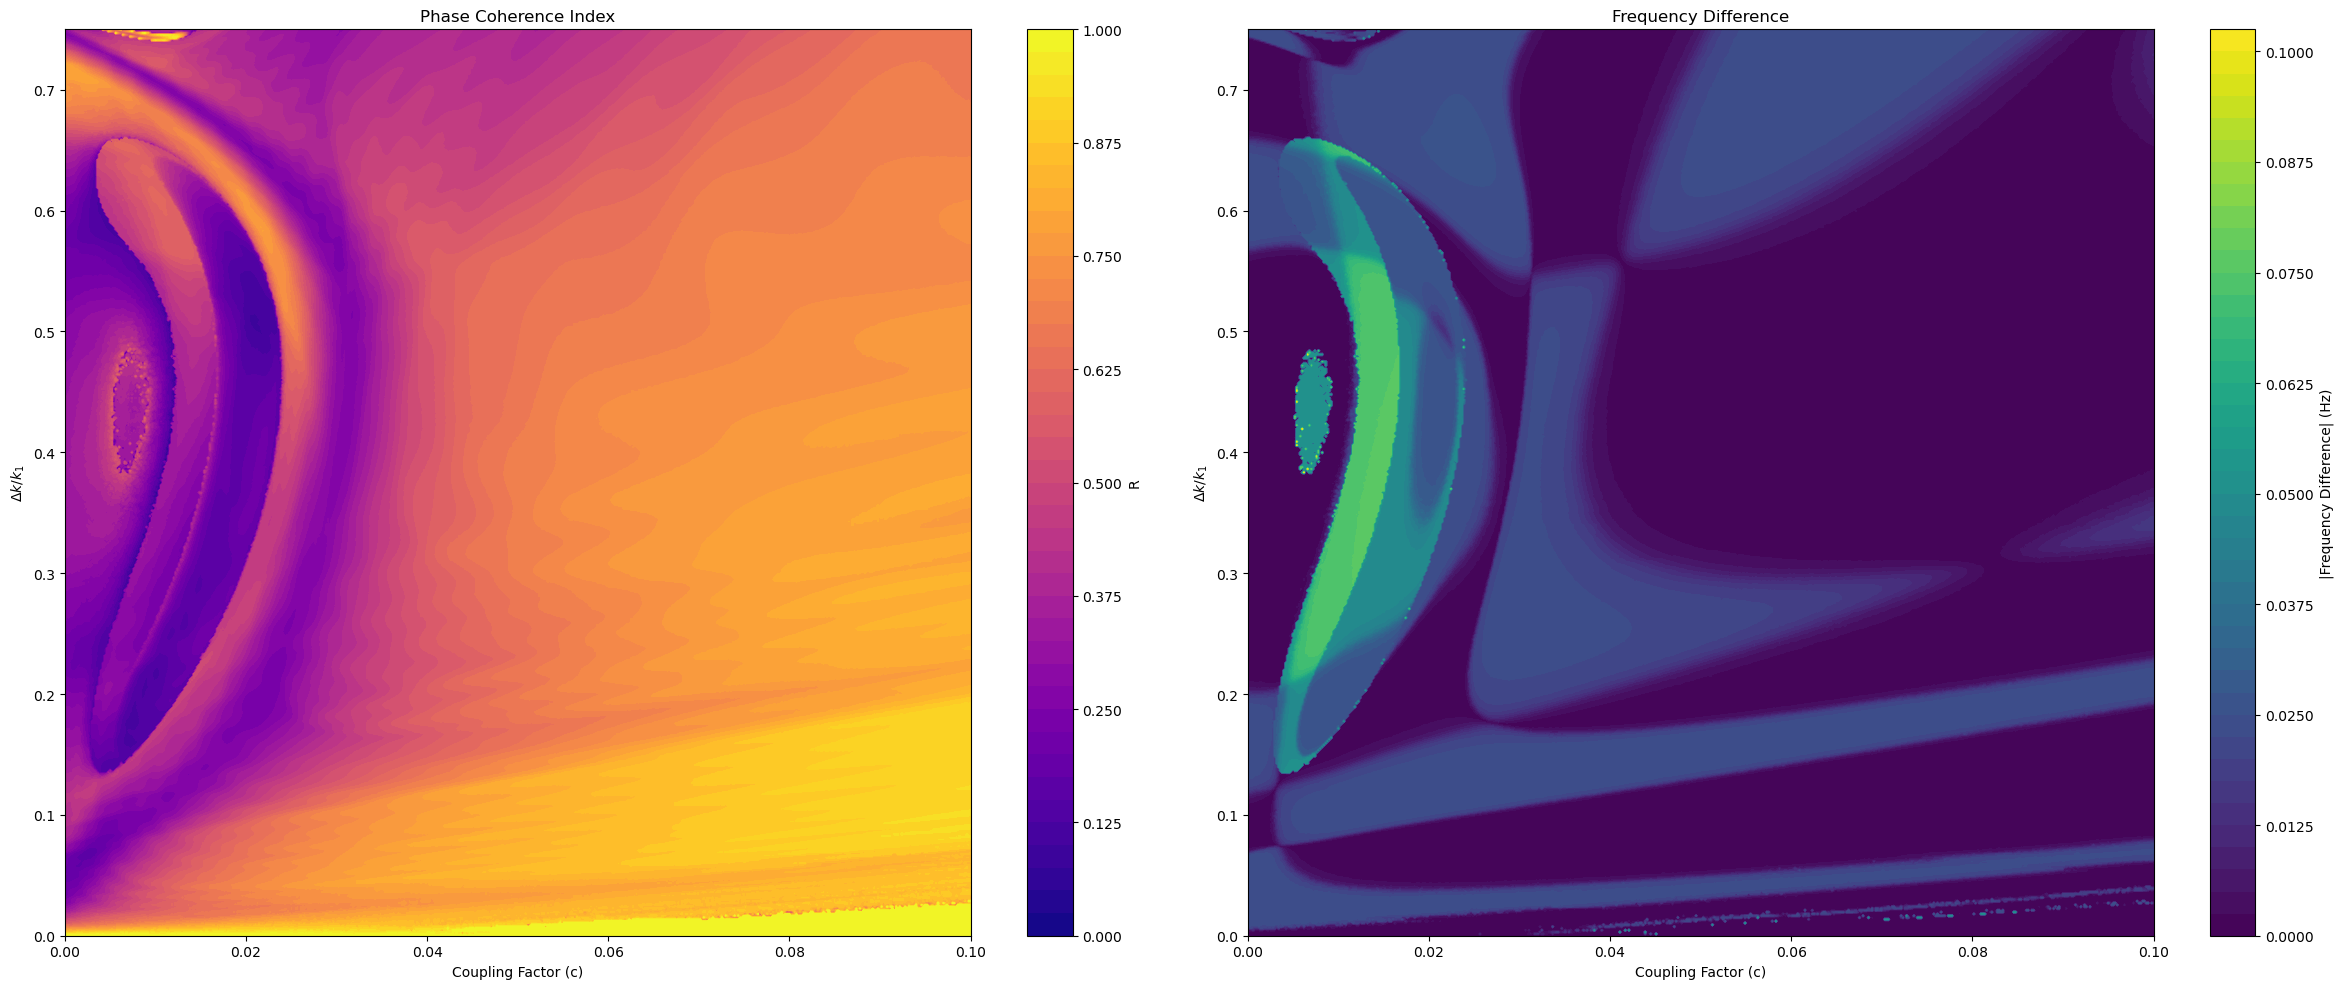

In [10]:
plot_results(c_vals, delta_ratios, freq_diff, R_mat)

In [16]:
np.save("wavelet_goodR.npy", R_mat)
np.save("wavelet_goodf", freq_diff)

## p3 complexity measures

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from utils import run_complexity

c_vals, delta_ratios, lambda_x1, lambda_x2 = run_complexity(resolution=1000, 
                                                            measure='lyapunov', 
                                                            n_jobs=12)

1000it [1:00:58,  3.66s/it]


In [ ]:
import numpy as np
# np.save("lyapunovx1.npy", lambda_x1)
# np.save("lyapunovx2.npy", lambda_x2)

0.008401818458114902


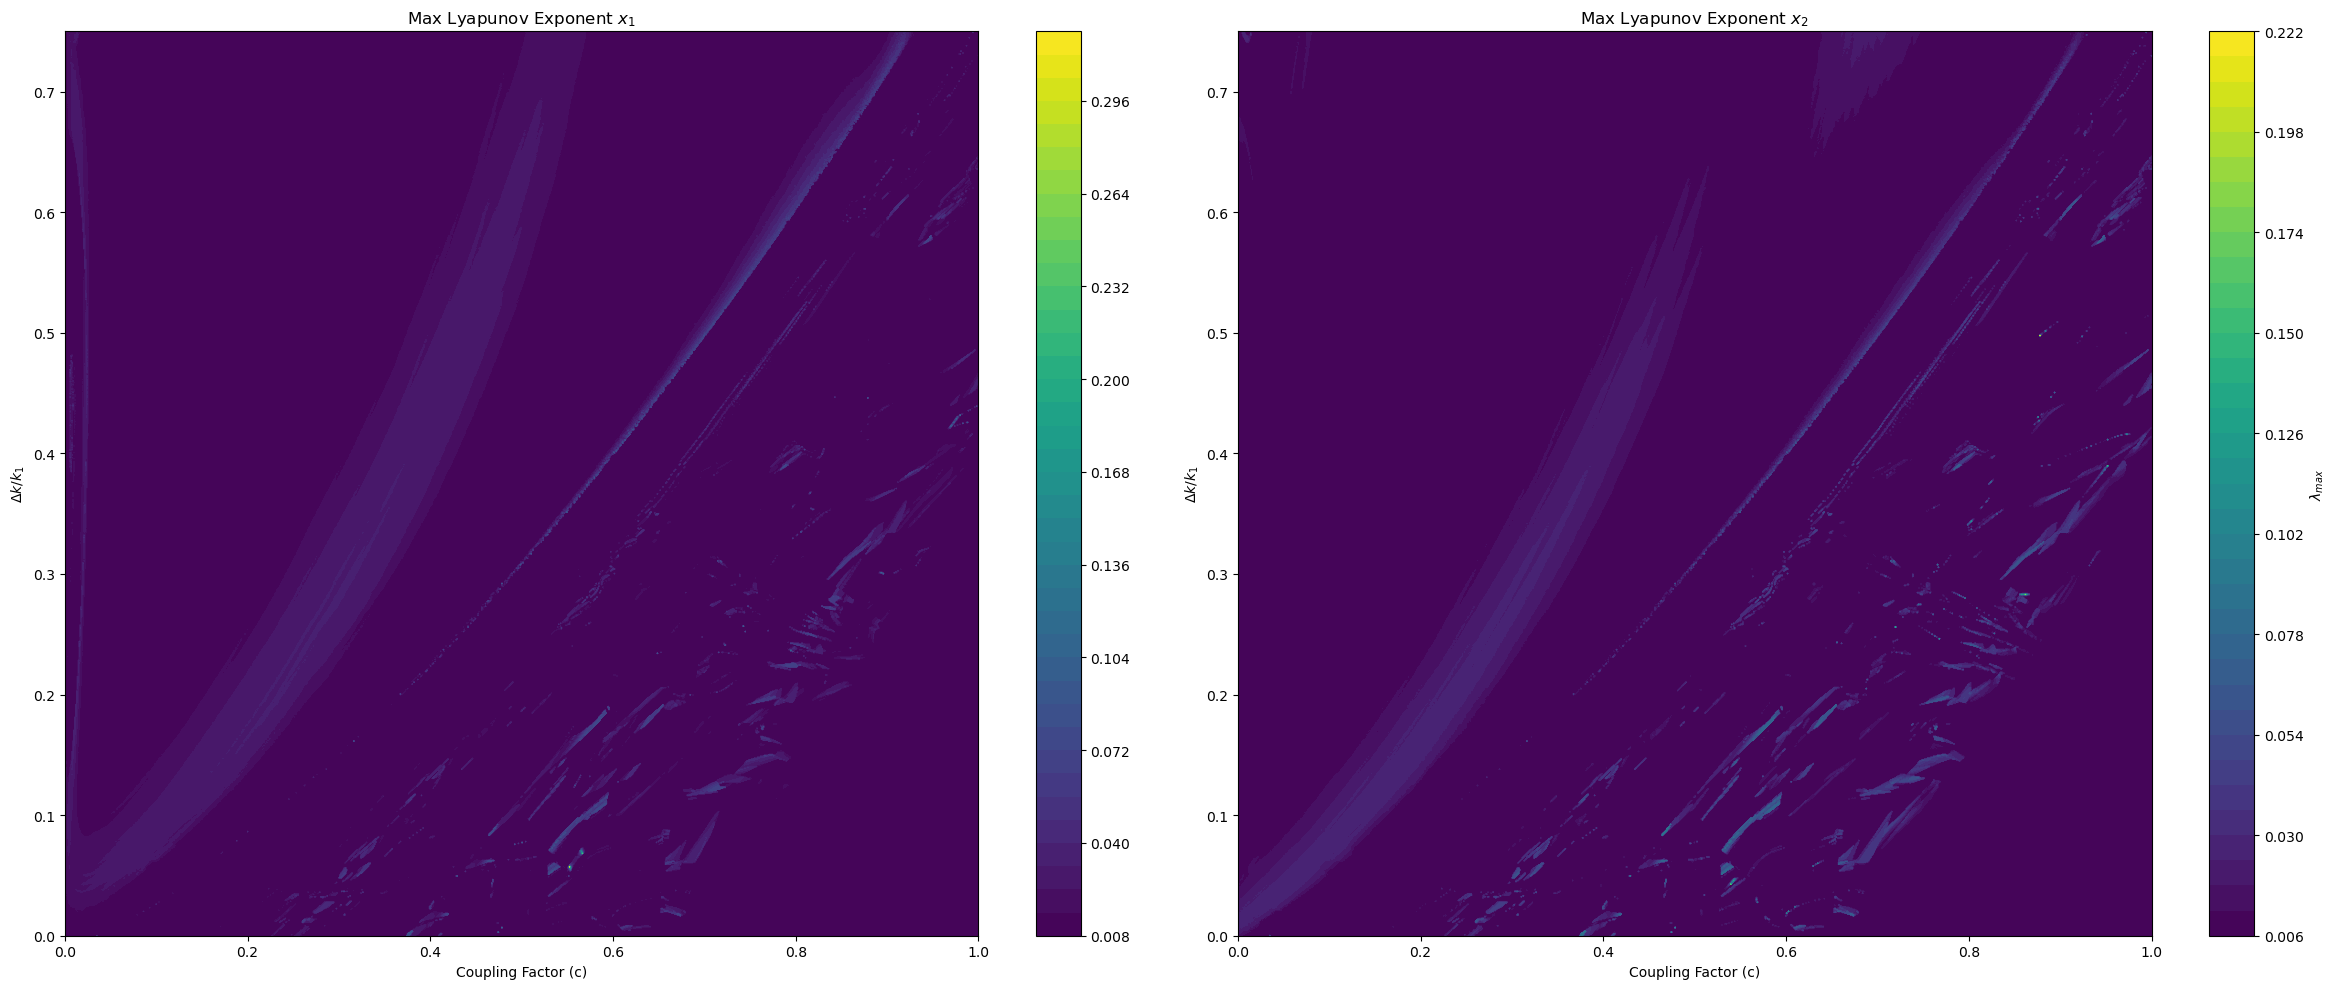

In [15]:
from utils import plot_complexity

plot_complexity(c_vals, delta_ratios, lambda_x1, lambda_x2, measure='lyapunov')

In [8]:
from utils import run_complexity

c_vals, delta_ratios, corrdim_x1, corrdim_x2 = run_complexity(resolution=1000, 
                                                              measure='correlation', 
                                                              n_jobs=16)

0it [00:00, ?it/s]

1000it [57:21,  3.44s/it]


In [ ]:
import numpy as np
# np.save("correlationdimx1.npy", corrdim_x1)
# np.save("correlationdimx2.npy", corrdim_x2)

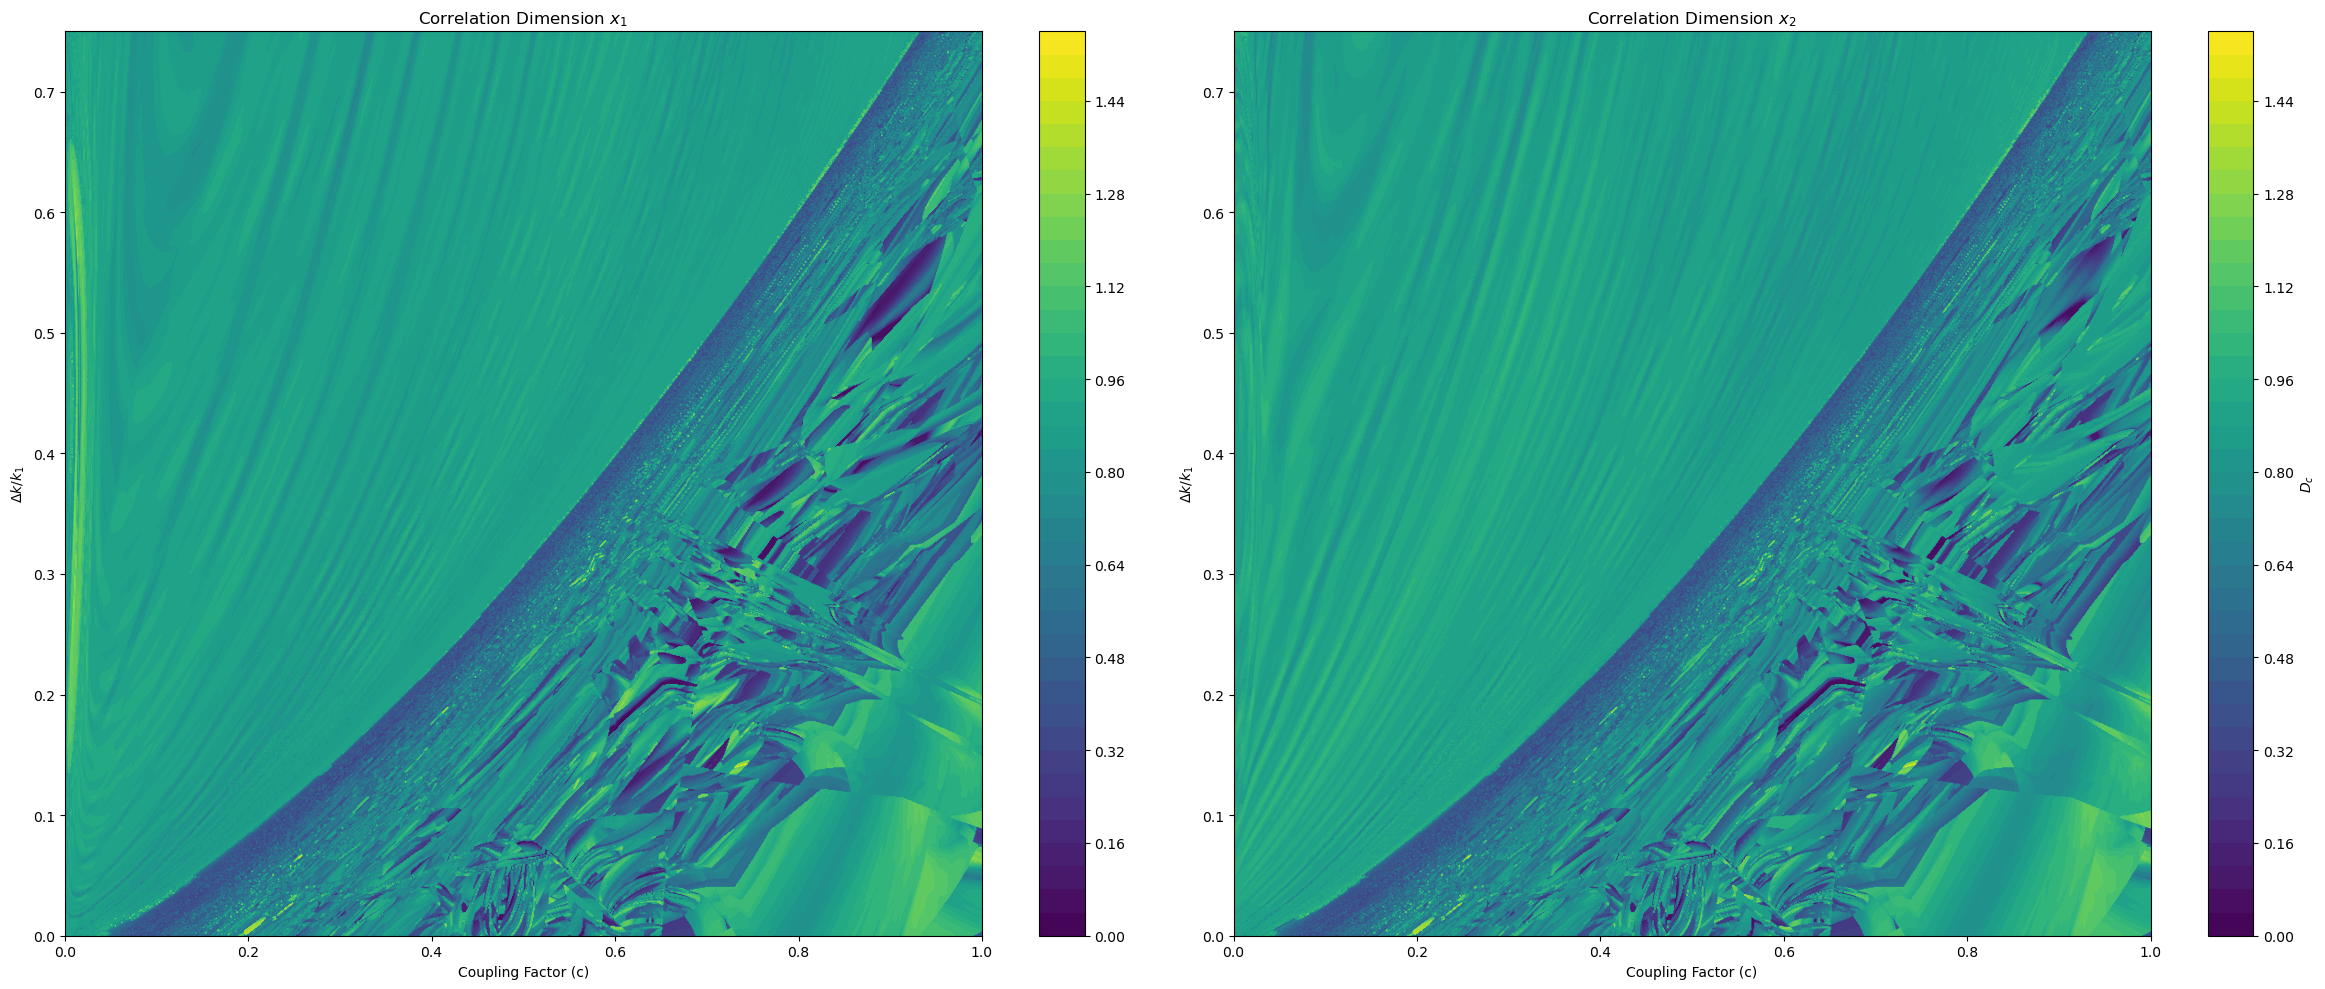

In [14]:
from utils import plot_complexity

plot_complexity(c_vals, delta_ratios, corrdim_x1, corrdim_x2, measure="correlation")